In [ ]:
%%capture
!pip install datasets transformers

In [ ]:
from transformers import BertTokenizer
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
from datasets import load_dataset
import unicodedata
import re

## Tokenizer


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
sent = "I love footballing"
ids = tokenizer.encode(sent)
for i in ids:
    print(i, tokenizer.ids_to_tokens[i])

101 [CLS]
1045 i
2293 love
2374 football
2075 ##ing
102 [SEP]


**Dataset**

We will use the IMDB dataset. It is a dataset with 2 classes: Positive and Negative. We download it from HuggingFace Hub [here](https://huggingface.co/datasets/fancyzhx/ag_news)

We will use only a very small subset of **64** annotated texts. This is a paradigm called "few shots learnings".


In [ ]:
dataset = load_dataset("stanfordnlp/imdb")
dataset = dataset["train"]
dataset = dataset.shuffle(seed=42)
dataset = dataset.train_test_split(test_size=0.3, seed=1234)
dataset["train"] = dataset["train"].select(range(64))
dataset["test"] = dataset["test"].select(range(1000))

print(dataset)


def preprocess_text(x):
    # TODO lower case
    text = x["text"]
    text = text.lower()

    # TODO string normalization.
    text = unicodedata.normalize("NFD", text).encode("ascii", "ignore").decode()

    # TODO remove non alpha numeric characters.
    text = re.sub(r"[^a-z0-9]", " ", text)

    # TODO replace numbers by the <NUM> token.
    text = re.sub(r"\d+", "<NUM>", text)

    # TODO remove double whitespaces.
    text = re.sub(" +", " ", text.strip())
    ids = tokenizer(text, truncation=True, max_length=256, padding=False)["input_ids"]
    return {"input_ids": ids}


# Clean the dataset and tokenize it directly
dataset = dataset.map(preprocess_text)

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 64
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
class DataCollator:
    def __init__(self, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __call__(self, batch):
        # Tokenize the texts
        labels = [example["label"] for example in batch]
        tokenized_texts = [example["input_ids"] for example in batch]
        # Pad the tokenized texts
        max_len = max(len(text) for text in tokenized_texts)
        padded_texts = [
            text + [self.tokenizer.pad_token_id] * (max_len - len(text))
            for text in tokenized_texts
        ]
        pad_mask = [
            [1] * len(text) + [0] * (max_len - len(text)) for text in tokenized_texts
        ]
        return {
            "input_ids": torch.tensor(padded_texts),
            "pad_mask": torch.tensor(pad_mask),
            "labels": torch.tensor(labels),
        }

In [ ]:
# TODO
def validation_step(valid_dataloader, model, criterion):
    n_valid = len(valid_dataloader.dataset)
    model.eval()
    total_loss = 0.0
    correct = 0
    n_iter = 0
    with torch.no_grad():
        for batch in valid_dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            pad_mask = batch["pad_mask"].to(DEVICE)
            output = model(input_ids, pad_mask)
            loss = criterion(output, labels)
            total_loss += loss.item()
            correct += (output.argmax(axis=-1) == labels).sum().item()
            n_iter += 1
    return total_loss / n_iter, correct / n_valid


def train_one_epoch(train_dataloader, model, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    n_train = len(train_dataloader.dataset)
    n_iter = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        pad_mask = batch["pad_mask"].to(DEVICE)
        class_scores = model(input_ids, pad_mask)  # (B, 4)

        loss = criterion(class_scores, labels)  # scalaire (1,)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (class_scores.argmax(axis=-1) == labels).sum().item()
        n_iter += 1

    return total_loss / n_iter, correct / n_train


def train(model, train_dataloader, valid_dataloader, lr=0.01, n_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Track training loss, training accuracy, validation loss and validation accuracy and plot in the end
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    model.to(DEVICE)
    for epoch in range(n_epochs):
        train_loss, train_accuracy = train_one_epoch(
            train_dataloader, model, optimizer, criterion
        )
        valid_loss, valid_accuracy = validation_step(valid_dataloader, model, criterion)
        print(
            f"Epoch {epoch + 1}: train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}, valid_loss: {valid_loss:.4f}, valid_accuracy: {valid_accuracy:.4f}"
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="train loss")
    plt.plot(valid_losses, label="valid loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="train accuracy")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()

In [ ]:
batch_size = 4
n_train = len(dataset["train"])
n_valid = len(dataset["test"])
data_collator = DataCollator(tokenizer)
train_dataloader = DataLoader(
    dataset["train"], batch_size=batch_size, collate_fn=data_collator, shuffle=True
)
valid_dataloader = DataLoader(
    dataset["test"], batch_size=batch_size, collate_fn=data_collator, shuffle=True
)

In [ ]:
class WordEmbedClassifier(nn.Module):
    def __init__(self, vocab_size, d, n_classes=4):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, d)
        self.class_projection = nn.Linear(d, n_classes)

    def forward(self, input_ids, pad_mask):
        x_embed = self.embedding_layer(input_ids)  # (B, L, d)

        # x_vector = x_embeds.mean(axis=1) # (B, d)
        n_non_pad = pad_mask.sum(
            axis=1, keepdim=True
        )  # (B, 1), 1 because of keepdim=True

        # pad_mask (B, L), x_embed (B, L, d)
        x_embed = x_embed * pad_mask[:, :, None]  # or pad_mask.unsqueeze(-1)
        x_vector = x_embed.sum(axis=1) / n_non_pad

        class_scores = self.class_projection(x_vector)  # (B, n_classes)

        return class_scores

Epoch 1: train_loss: 1.1784, train_accuracy: 0.3906, valid_loss: 0.9011, valid_accuracy: 0.5370
Epoch 2: train_loss: 0.7383, train_accuracy: 0.7031, valid_loss: 0.7307, valid_accuracy: 0.5370
Epoch 3: train_loss: 0.5562, train_accuracy: 0.8438, valid_loss: 0.6894, valid_accuracy: 0.5990
Epoch 4: train_loss: 0.3764, train_accuracy: 0.9844, valid_loss: 0.6644, valid_accuracy: 0.6170
Epoch 5: train_loss: 0.2276, train_accuracy: 1.0000, valid_loss: 0.6513, valid_accuracy: 0.6340
Epoch 6: train_loss: 0.1188, train_accuracy: 1.0000, valid_loss: 0.6567, valid_accuracy: 0.6440
Epoch 7: train_loss: 0.0597, train_accuracy: 1.0000, valid_loss: 0.6446, valid_accuracy: 0.6440
Epoch 8: train_loss: 0.0364, train_accuracy: 1.0000, valid_loss: 0.6438, valid_accuracy: 0.6540
Epoch 9: train_loss: 0.0247, train_accuracy: 1.0000, valid_loss: 0.6466, valid_accuracy: 0.6590
Epoch 10: train_loss: 0.0178, train_accuracy: 1.0000, valid_loss: 0.6503, valid_accuracy: 0.6610


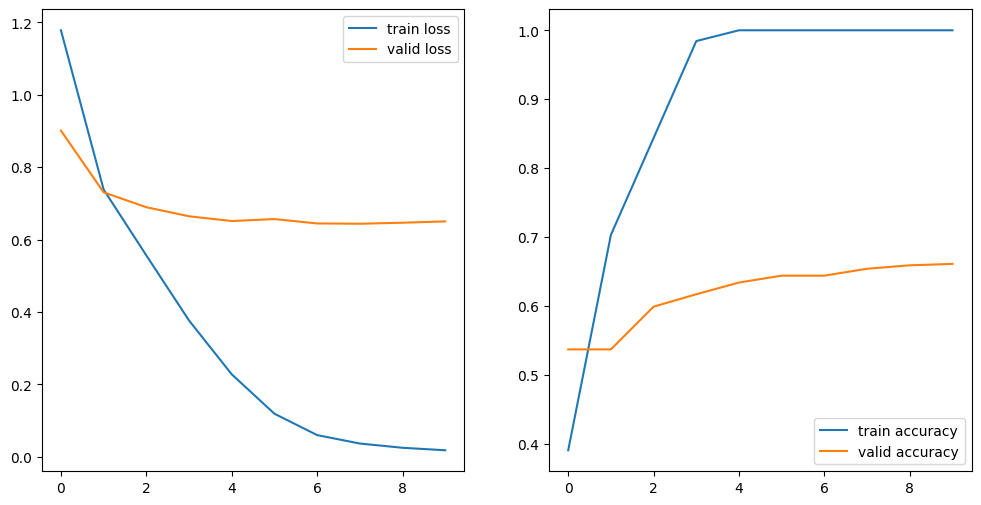

In [ ]:
model = WordEmbedClassifier(
    d=50,
    n_classes=4,
    vocab_size=len(tokenizer),
)
train(
    model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    lr=0.01,
    n_epochs=10,
)

**1. Write a function load_model that takes a path to a saved Word2Vec
embeddings (with the previous formatting) and loads the checkpoint the
embeddings directly to the WordEmbedClassifier.**

Our model is based on a Word2Vec architecture consisting of two distinct embedding matrices: **word_embed**, which represents word embeddings, and **context_embed**, which captures contextual relationships. However, in our application, only the word embedding (**word_embed**) is used for training and inference. Therefore, when loading the model, we extract this component exclusively to initialize our WordEmbedClassifier.

In [ ]:
def load_model(ckpt_path, vocab_size, embed_dim, num_classes):
    # Load the saved state_dict with weights_only=True to mitigate security risks
    checkpoint = torch.load(ckpt_path, map_location='cpu', weights_only=True)

    # Extract the word embeddings directly
    word_embeddings = checkpoint['word_embed.weight']

    # Initialize the WordEmbedClassifier
    model = WordEmbedClassifier(vocab_size=vocab_size, d=embed_dim, n_classes=num_classes)

    # Load the embeddings into the embedding layer
    model.embedding_layer.weight = nn.Parameter(word_embeddings)

    return model

**2. Train the model, initialized with these emebeddings.**

Epoch 1: train_loss: 1.0461, train_accuracy: 0.4531, valid_loss: 0.7629, valid_accuracy: 0.5940
Epoch 2: train_loss: 0.5974, train_accuracy: 0.8438, valid_loss: 0.6646, valid_accuracy: 0.6230
Epoch 3: train_loss: 0.3866, train_accuracy: 0.9219, valid_loss: 0.6341, valid_accuracy: 0.6460
Epoch 4: train_loss: 0.1936, train_accuracy: 0.9844, valid_loss: 0.6275, valid_accuracy: 0.6600
Epoch 5: train_loss: 0.0760, train_accuracy: 1.0000, valid_loss: 0.6176, valid_accuracy: 0.6710
Epoch 6: train_loss: 0.0283, train_accuracy: 1.0000, valid_loss: 0.6204, valid_accuracy: 0.6690
Epoch 7: train_loss: 0.0165, train_accuracy: 1.0000, valid_loss: 0.6113, valid_accuracy: 0.6740
Epoch 8: train_loss: 0.0105, train_accuracy: 1.0000, valid_loss: 0.6122, valid_accuracy: 0.6730
Epoch 9: train_loss: 0.0078, train_accuracy: 1.0000, valid_loss: 0.6182, valid_accuracy: 0.6730
Epoch 10: train_loss: 0.0062, train_accuracy: 1.0000, valid_loss: 0.6164, valid_accuracy: 0.6750


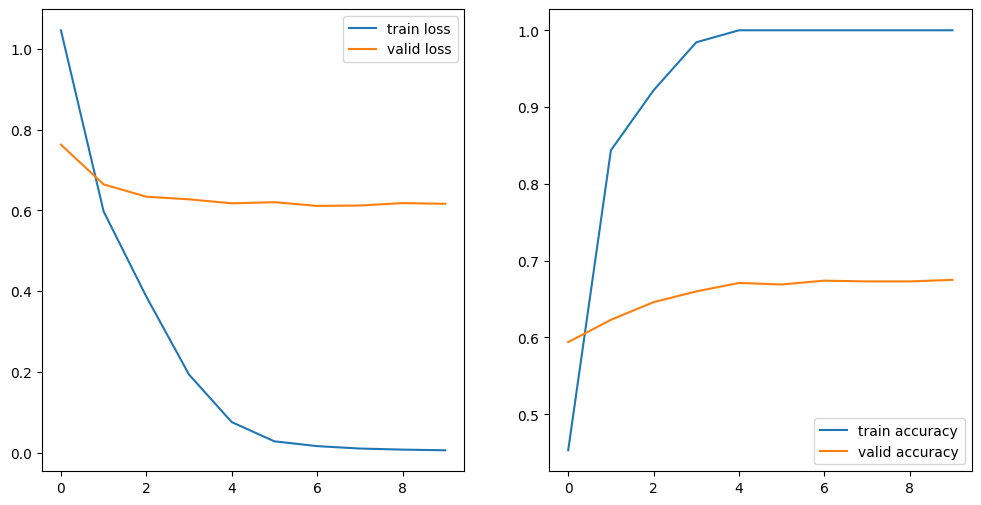

In [ ]:
# Load the model with Word2Vec embeddings
ckpt_path = "/content/model_dim-100_radius-5_ratio-2-batch-32-epoch-10.ckpt"
model_with_w2v = load_model(
    ckpt_path=ckpt_path,
    vocab_size=len(tokenizer),
    embed_dim=100,  # Match the embedding dimension with the checkpoint
    num_classes=4
)

train(
    model_with_w2v,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    lr=0.01,
    n_epochs=10,
)

**3. Compare the results with the model without this initialization.**

In this analysis, we will compare the performance of the model with and without Word2Vec initialization using several key metrics. We will examine validation accuracy, validation loss, the F1-score, the confusion matrix, and the ROC and Precision-Recall curves.

Epoch 1: train_loss: 1.0593, train_accuracy: 0.4844, valid_loss: 0.7900, valid_accuracy: 0.5330
Epoch 2: train_loss: 0.6112, train_accuracy: 0.7969, valid_loss: 0.6905, valid_accuracy: 0.5790
Epoch 3: train_loss: 0.4042, train_accuracy: 0.9844, valid_loss: 0.6773, valid_accuracy: 0.6150
Epoch 4: train_loss: 0.2128, train_accuracy: 0.9844, valid_loss: 0.6599, valid_accuracy: 0.6210
Epoch 5: train_loss: 0.0835, train_accuracy: 1.0000, valid_loss: 0.6591, valid_accuracy: 0.6380
Epoch 6: train_loss: 0.0378, train_accuracy: 1.0000, valid_loss: 0.6706, valid_accuracy: 0.6560
Epoch 7: train_loss: 0.0196, train_accuracy: 1.0000, valid_loss: 0.6591, valid_accuracy: 0.6470
Epoch 8: train_loss: 0.0130, train_accuracy: 1.0000, valid_loss: 0.6650, valid_accuracy: 0.6500
Epoch 9: train_loss: 0.0096, train_accuracy: 1.0000, valid_loss: 0.6724, valid_accuracy: 0.6500
Epoch 10: train_loss: 0.0075, train_accuracy: 1.0000, valid_loss: 0.6743, valid_accuracy: 0.6460
Epoch 1: train_loss: 1.0516, train_accu

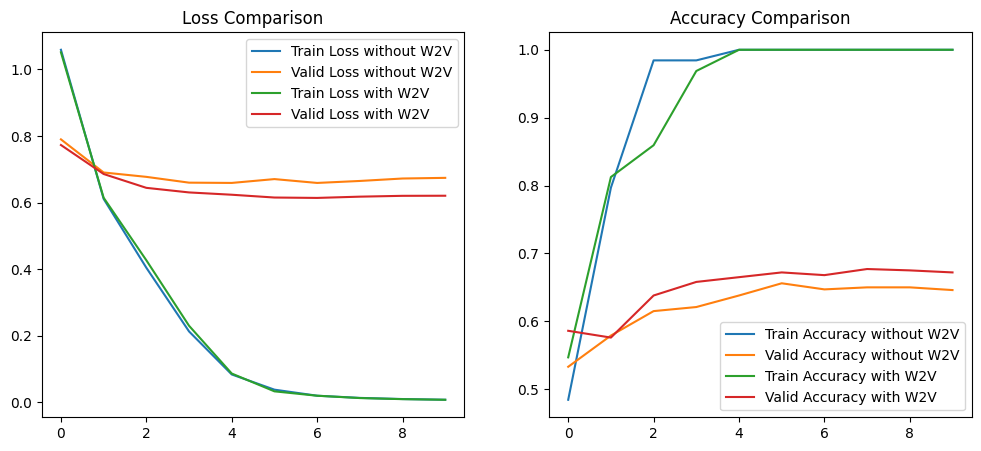

In [ ]:
import matplotlib.pyplot as plt

# Train the model without Word2Vec embeddings
model_without_w2v = WordEmbedClassifier(
    d=100,
    n_classes=4,
    vocab_size=len(tokenizer),
)

train_losses_no_w2v, train_accuracies_no_w2v, valid_losses_no_w2v, valid_accuracies_no_w2v = [], [], [], []

def train_and_store(model, train_dataloader, valid_dataloader, lr, n_epochs, losses, accuracies):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(DEVICE)
    for epoch in range(n_epochs):
        train_loss, train_accuracy = train_one_epoch(train_dataloader, model, optimizer, criterion)
        valid_loss, valid_accuracy = validation_step(valid_dataloader, model, criterion)
        print(f"Epoch {epoch + 1}: train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}, valid_loss: {valid_loss:.4f}, valid_accuracy: {valid_accuracy:.4f}")
        losses[0].append(train_loss)
        losses[1].append(valid_loss)
        accuracies[0].append(train_accuracy)
        accuracies[1].append(valid_accuracy)

train_and_store(model_without_w2v, train_dataloader, valid_dataloader, lr=0.01, n_epochs=10,
                losses=[train_losses_no_w2v, valid_losses_no_w2v],
                accuracies=[train_accuracies_no_w2v, valid_accuracies_no_w2v])

# Train the model with Word2Vec embeddings
ckpt_path = "/content/model_dim-100_radius-5_ratio-2-batch-32-epoch-10.ckpt"
model_with_w2v = load_model(
    ckpt_path=ckpt_path,
    vocab_size=len(tokenizer),
    embed_dim=100,
    num_classes=4
)

train_losses_w2v, train_accuracies_w2v, valid_losses_w2v, valid_accuracies_w2v = [], [], [], []

train_and_store(model_with_w2v, train_dataloader, valid_dataloader, lr=0.01, n_epochs=10,
                losses=[train_losses_w2v, valid_losses_w2v],
                accuracies=[train_accuracies_w2v, valid_accuracies_w2v])

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_no_w2v, label='Train Loss without W2V')
plt.plot(valid_losses_no_w2v, label='Valid Loss without W2V')
plt.plot(train_losses_w2v, label='Train Loss with W2V')
plt.plot(valid_losses_w2v, label='Valid Loss with W2V')
plt.title('Loss Comparison')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_no_w2v, label='Train Accuracy without W2V')
plt.plot(valid_accuracies_no_w2v, label='Valid Accuracy without W2V')
plt.plot(train_accuracies_w2v, label='Train Accuracy with W2V')
plt.plot(valid_accuracies_w2v, label='Valid Accuracy with W2V')
plt.title('Accuracy Comparison')
plt.legend()

plt.show()


**Validation_score(loss, accuracy)**

In [ ]:
# Final validation accuracies and losses
final_valid_accuracy_no_w2v = valid_accuracies_no_w2v[-1]
final_valid_loss_no_w2v = valid_losses_no_w2v[-1]

final_valid_accuracy_w2v = valid_accuracies_w2v[-1]
final_valid_loss_w2v = valid_losses_w2v[-1]

# Print the final validation metrics
print(f"Validation Accuracy without W2V: {final_valid_accuracy_no_w2v:.4f}")
print(f"Validation Loss without W2V: {final_valid_loss_no_w2v:.4f}")
print(f"Validation Accuracy with W2V: {final_valid_accuracy_w2v:.4f}")
print(f"Validation Loss with W2V: {final_valid_loss_w2v:.4f}")

# Calculate the differences
accuracy_difference = final_valid_accuracy_w2v - final_valid_accuracy_no_w2v
loss_difference = final_valid_loss_no_w2v - final_valid_loss_w2v

print(f"Accuracy Improvement with W2V: {accuracy_difference:.4f}")
print(f"Loss Reduction with W2V: {loss_difference:.4f}")


Validation Accuracy without W2V: 0.6460
Validation Loss without W2V: 0.6743
Validation Accuracy with W2V: 0.6720
Validation Loss with W2V: 0.6206
Accuracy Improvement with W2V: 0.0260
Loss Reduction with W2V: 0.0537


**Confusion-Matrix**

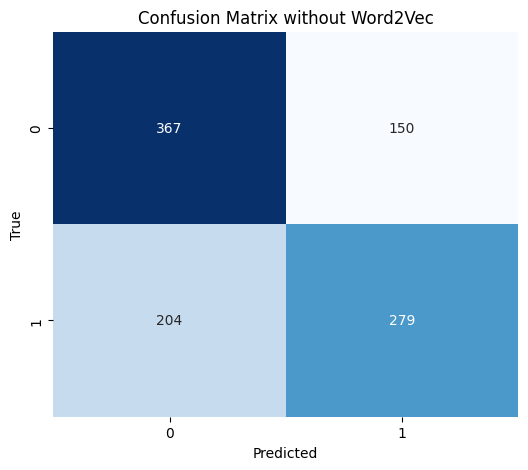

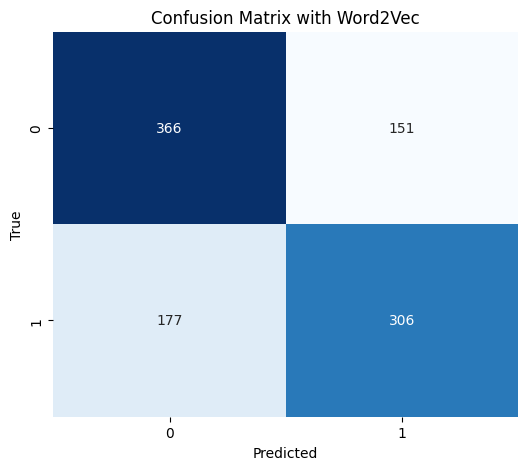

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def compute_confusion_matrix(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            pad_mask = batch["pad_mask"].to(device)
            output = model(input_ids, pad_mask)
            preds = output.argmax(axis=-1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    return cm

# Compute confusion matrices for both models
cm_no_w2v = compute_confusion_matrix(model_without_w2v, valid_dataloader, DEVICE)
cm_w2v = compute_confusion_matrix(model_with_w2v, valid_dataloader, DEVICE)

# Plot confusion matrices
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=range(2), yticklabels=range(2))
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(cm_no_w2v, 'Confusion Matrix without Word2Vec')
plot_confusion_matrix(cm_w2v, 'Confusion Matrix with Word2Vec')


**Precision Recall Curve**

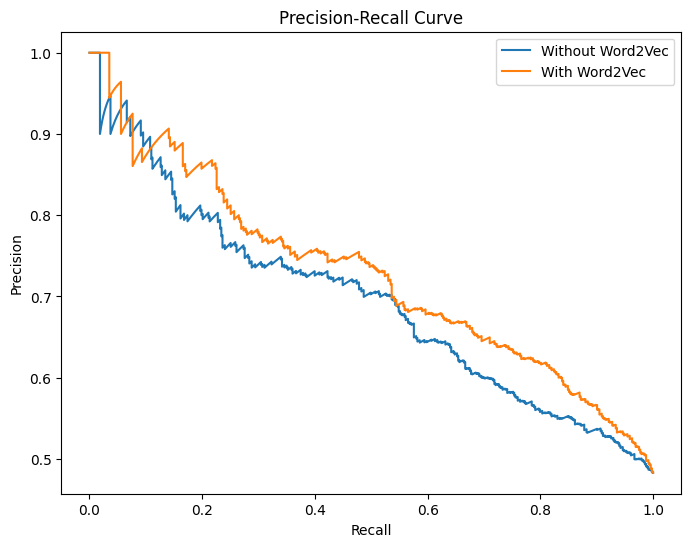

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_precision_recall_curves(models, dataloader, labels, title="Precision-Recall Curve"):
    plt.figure(figsize=(8, 6))

    for model, label in zip(models, labels):
        model.eval()
        all_labels = []
        all_scores = []

        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch["input_ids"].to(DEVICE)
                labels_batch = batch["labels"].to(DEVICE)
                pad_mask = batch["pad_mask"].to(DEVICE)

                output = model(input_ids, pad_mask)
                scores = torch.softmax(output, dim=-1)[:, 1].cpu().numpy()

                all_labels.extend(labels_batch.cpu().numpy())
                all_scores.extend(scores)

        precision, recall, _ = precision_recall_curve(all_labels, all_scores)

        plt.plot(recall, precision, label=label)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend()
    plt.show()

plot_precision_recall_curves(
    models=[model_without_w2v, model_with_w2v],
    dataloader=valid_dataloader,
    labels=["Without Word2Vec", "With Word2Vec"]
)

**f1_score**

In [ ]:
from sklearn.metrics import f1_score

def compute_f1_score(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            pad_mask = batch["pad_mask"].to(device)
            output = model(input_ids, pad_mask)
            preds = output.argmax(axis=-1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    return f1

# Compute F1 scores for both models
f1_no_w2v = compute_f1_score(model_without_w2v, valid_dataloader, DEVICE)
f1_w2v = compute_f1_score(model_with_w2v, valid_dataloader, DEVICE)

# Print F1 scores
print(f"F1 Score without Word2Vec: {f1_no_w2v:.4f}")
print(f"F1 Score with Word2Vec: {f1_w2v:.4f}")


F1 Score without Word2Vec: 0.6443
F1 Score with Word2Vec: 0.6715


**ROC_CURVE**

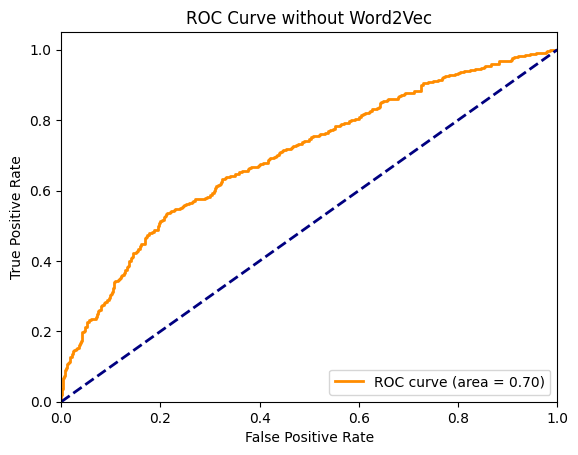

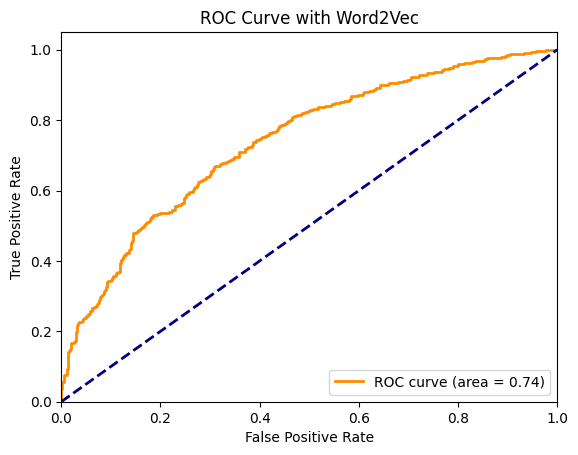

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(model, dataloader, title):
    model.eval()
    all_labels = []
    all_scores = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            pad_mask = batch["pad_mask"].to(DEVICE)
            output = model(input_ids, pad_mask)
            scores = torch.softmax(output, dim=-1)[:, 1].cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(scores)

    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curves for both models
plot_roc_curve(model_without_w2v, valid_dataloader, 'ROC Curve without Word2Vec')
plot_roc_curve(model_with_w2v, valid_dataloader, 'ROC Curve with Word2Vec')


## **Analysis**

Initializing the model with pre-trained Word2Vec embeddings provides a modest improvement in performance.

We observe a +2% increase in validation accuracy, suggesting a slight enhancement in generalization, along with a 0.0594 reduction in validation loss, indicating marginally more stable convergence.

The higher F1-score suggests a better balance between precision and recall, helping to reduce classification errors.

Analysis of the confusion matrices reveals a small decrease in false positives and false negatives, slightly improving the model's ability to distinguish between classes.

The Precision-Recall (PR) and ROC curves align with this trend, showing a minor increase in the area under the curve, which reflects a modest gain in class discrimination.

 While Word2Vec helps the model better capture semantic relationships, its impact on overfitting and overall robustness remains moderate in this specific setting.

**4. Make a small ablation study on the influence of some parameters of the
Word2Vec model on the classification task. Analyze the results.**

We conducted an ablation study by systematically training models using pre-trained checkpoints with varying configurations.

We focused on key parameters such as embedding dimensions **(model_dim)**, context window sizes **(radius R)**, and negative sampling ratios **(ratio K)**, while maintaining a constant batch size of 32 and training for 10 epochs.

We began by preparing data loaders and defining the training parameters, including context sizes and the number of epochs.

Each model was trained using a specific configuration to evaluate its impact on performance metrics such as validation accuracy and loss. By training models with configurations like "model_dim-50_radius-3_ratio-2-batch-32-epoch-10.ckpt" and others, we aimed to understand how each parameter influences the model's performance.

In [ ]:
# Define pre-trained model paths for different ratios, embedding dimensions, and radius values
ckpt_paths = {
    "ratio": {
        "Ratio 2": "/content/model_dim-100_radius-3_ratio-2-batch-32-epoch-10.ckpt",
        "Ratio 7": "/content/model_dim-100_radius-3_ratio-7-batch-32-epoch-10.ckpt",
        "Ratio 10": "/content/model_dim-100_radius-3_ratio-10-batch-32-epoch-10.ckpt"
    },
    "embedding": {
        "Embedding Dim 50": "/content/model_dim-50_radius-3_ratio-2-batch-32-epoch-10.ckpt",
        "Embedding Dim 100": "/content/model_dim-100_radius-3_ratio-2-batch-32-epoch-10.ckpt",
        "Embedding Dim 200": "/content/model_dim-200_radius-3_ratio-2-batch-32-epoch-10.ckpt"
    },
    "radius": {
        "Radius 3": "/content/model_dim-100_radius-3_ratio-2-batch-32-epoch-10.ckpt",
        "Radius 5": "/content/model_dim-100_radius-4_ratio-2-batch-32-epoch-10.ckpt",
        "Radius 10": "/content/model_dim-100_radius-7_ratio-2-batch-32-epoch-10.ckpt"


    }
}

def load_models(model_type):
    """
    Loads WordEmbedClassifier models for a given model type ('ratio', 'embedding', or 'radius').
    """
    return {
        label: load_model(
            ckpt,
            vocab_size=len(tokenizer),
            embed_dim=int(label.split()[-1]) if model_type == "embedding" else 100,
            num_classes=4
        )
        for label, ckpt in ckpt_paths[model_type].items()
    }

def train_models(models):
    """
    Trains models and stores results in a dictionary.
    """
    results = {}

    for label, model in models.items():
        print(f"\nTraining model with {label}: ")

        train_losses, valid_losses = [], []
        train_accuracies, valid_accuracies = [], []

        # Train and store results
        train_and_store(model, train_dataloader, valid_dataloader, lr=0.01, n_epochs=10,
                        losses=[train_losses, valid_losses], accuracies=[train_accuracies, valid_accuracies])

        # Save results
        results[label] = (train_losses, train_accuracies, valid_losses, valid_accuracies)

    return results

# Load models
models_ratio = load_models("ratio")
models_embed = load_models("embedding")
models_radius = load_models("radius")

# Train models and store results
results_ratio = train_models(models_ratio)
results_embed = train_models(models_embed)
results_radius = train_models(models_radius)



Training model with Ratio 2: 
Epoch 1: train_loss: 1.0531, train_accuracy: 0.6094, valid_loss: 0.7845, valid_accuracy: 0.5910
Epoch 2: train_loss: 0.6134, train_accuracy: 0.8125, valid_loss: 0.6743, valid_accuracy: 0.5980
Epoch 3: train_loss: 0.3849, train_accuracy: 0.9219, valid_loss: 0.6653, valid_accuracy: 0.6020
Epoch 4: train_loss: 0.1760, train_accuracy: 0.9844, valid_loss: 0.6390, valid_accuracy: 0.6390
Epoch 5: train_loss: 0.0650, train_accuracy: 1.0000, valid_loss: 0.6360, valid_accuracy: 0.6550
Epoch 6: train_loss: 0.0271, train_accuracy: 1.0000, valid_loss: 0.6286, valid_accuracy: 0.6540
Epoch 7: train_loss: 0.0152, train_accuracy: 1.0000, valid_loss: 0.6285, valid_accuracy: 0.6660
Epoch 8: train_loss: 0.0101, train_accuracy: 1.0000, valid_loss: 0.6307, valid_accuracy: 0.6610
Epoch 9: train_loss: 0.0076, train_accuracy: 1.0000, valid_loss: 0.6361, valid_accuracy: 0.6570
Epoch 10: train_loss: 0.0059, train_accuracy: 1.0000, valid_loss: 0.6346, valid_accuracy: 0.6610

Trainin

We will compare the performance of these models by plotting, side by side, the evolution of loss and accuracy for both the training and validation sets.

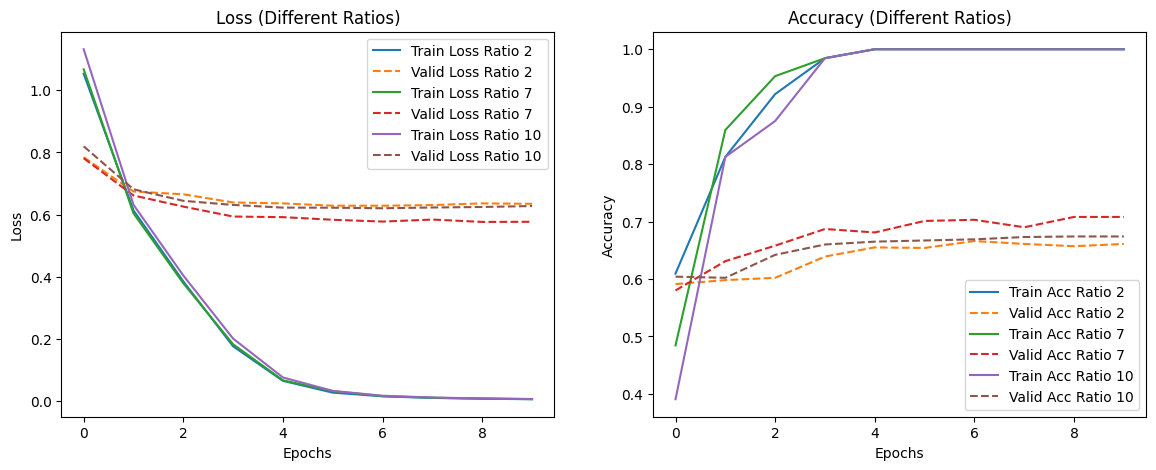

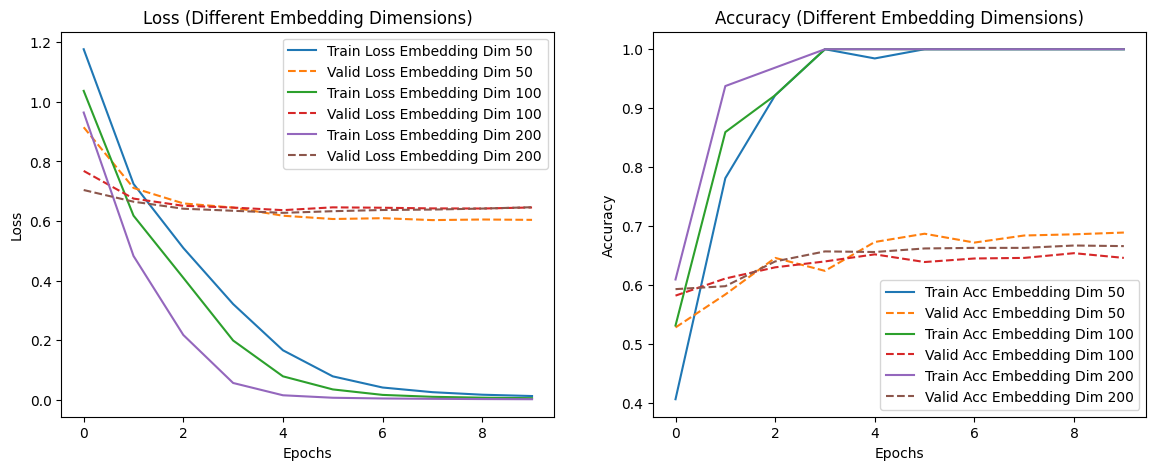

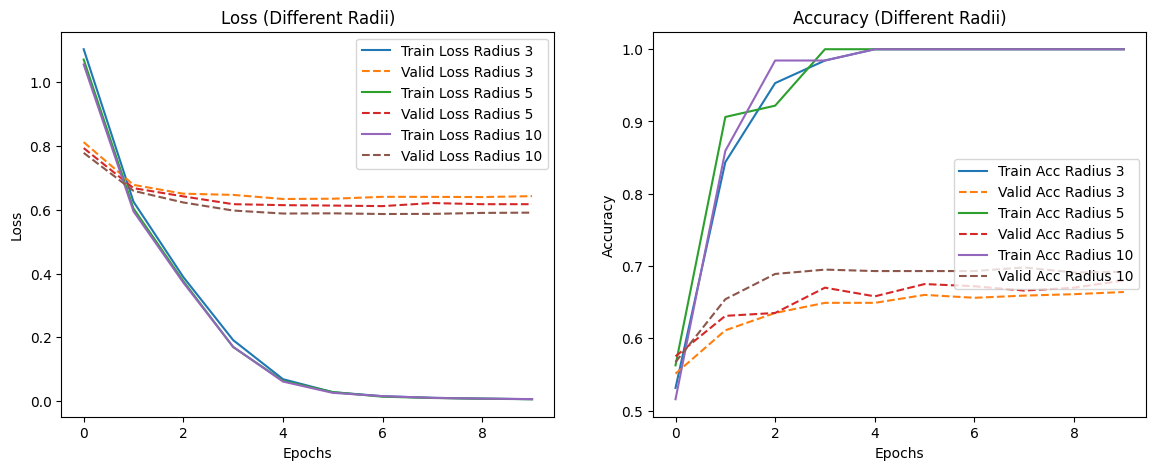

In [ ]:
def plot_results(results, title="Comparison"):
    """
    Plots loss and accuracy side by side for models trained with different ratios or embedding dimensions.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

    # Loss Comparison (Left Plot)
    axes[0].set_title(f"Loss {title}")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")

    # Accuracy Comparison (Right Plot)
    axes[1].set_title(f"Accuracy {title}")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")

    for label, values in results.items():
        train_losses, train_accuracies, valid_losses, valid_accuracies = values

        # Loss Plot
        axes[0].plot(train_losses, label=f"Train Loss {label}")
        axes[0].plot(valid_losses, label=f"Valid Loss {label}", linestyle="dashed")

        # Accuracy Plot
        axes[1].plot(train_accuracies, label=f"Train Acc {label}")
        axes[1].plot(valid_accuracies, label=f"Valid Acc {label}", linestyle="dashed")

    # Add legends
    axes[0].legend()
    axes[1].legend()

    plt.show()


plot_results(results_ratio, title="(Different Ratios)")
plot_results(results_embed, title="(Different Embedding Dimensions)")
plot_results(results_radius, title="(Different Radii)")

We display the maximum validation accuracy across different model configurations by plotting it on a line graph.








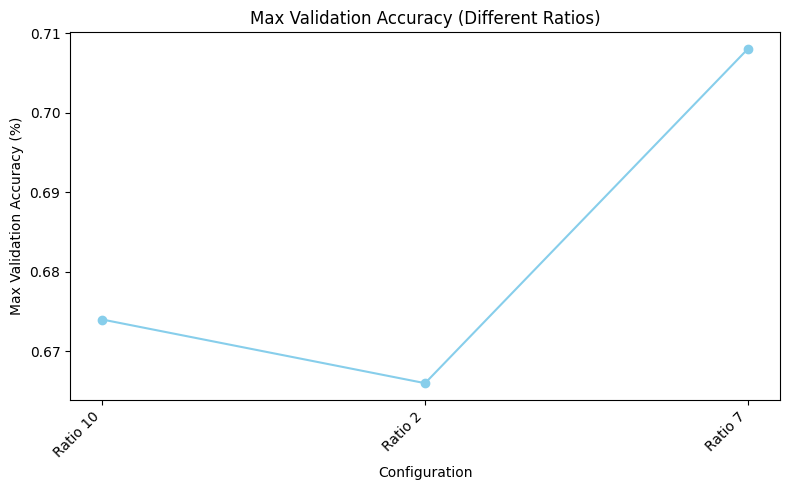

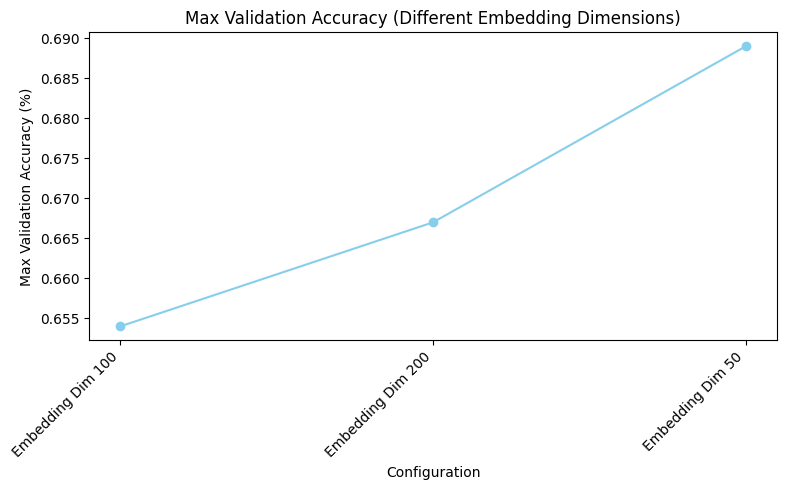

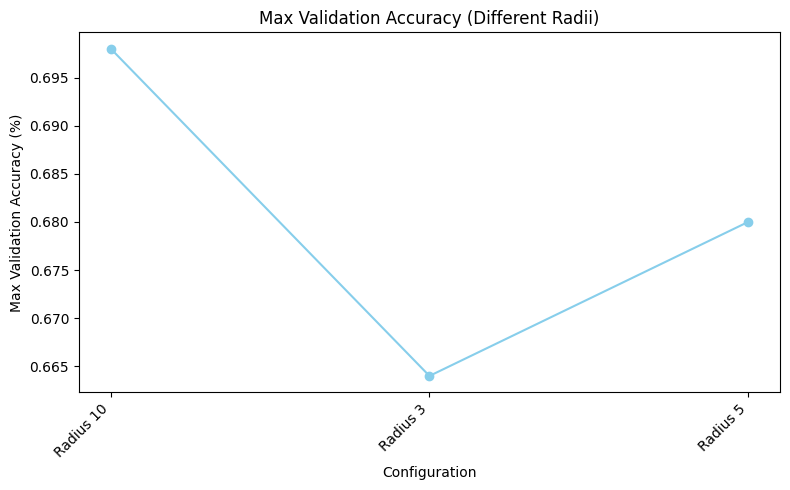

In [ ]:
import matplotlib.pyplot as plt

def plot_max_validation_accuracy(results, title="Max Validation Accuracy Comparison"):

    fig, ax = plt.subplots(figsize=(8, 5))

    # Max Validation Accuracy Plot
    ax.set_title(title)
    ax.set_xlabel("Configuration")
    ax.set_ylabel("Max Validation Accuracy (%)")

    max_valid_accuracies = []
    labels = []

    for label, values in results.items():
        _, _, _, valid_accuracies = values

        # Max Validation Accuracy
        max_valid_accuracy = max(valid_accuracies)
        max_valid_accuracies.append(max_valid_accuracy)
        labels.append(label)

    # Sort labels and accuracies for better plotting
    sorted_indices = sorted(range(len(labels)), key=lambda k: labels[k])
    labels = [labels[i] for i in sorted_indices]
    max_valid_accuracies = [max_valid_accuracies[i] for i in sorted_indices]

    # Plot Max Validation Accuracy
    ax.plot(labels, max_valid_accuracies, marker='o', linestyle='-', color='skyblue')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


plot_max_validation_accuracy(results_ratio, title="Max Validation Accuracy (Different Ratios)")
plot_max_validation_accuracy(results_embed, title="Max Validation Accuracy (Different Embedding Dimensions)")
plot_max_validation_accuracy(results_radius, title="Max Validation Accuracy (Different Radii)")


We compare model performance by plotting the maximum validation accuracy for different configurations.

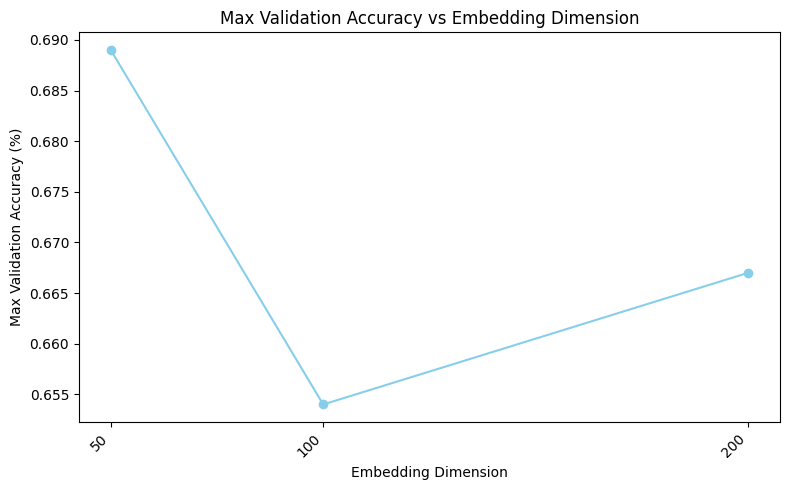

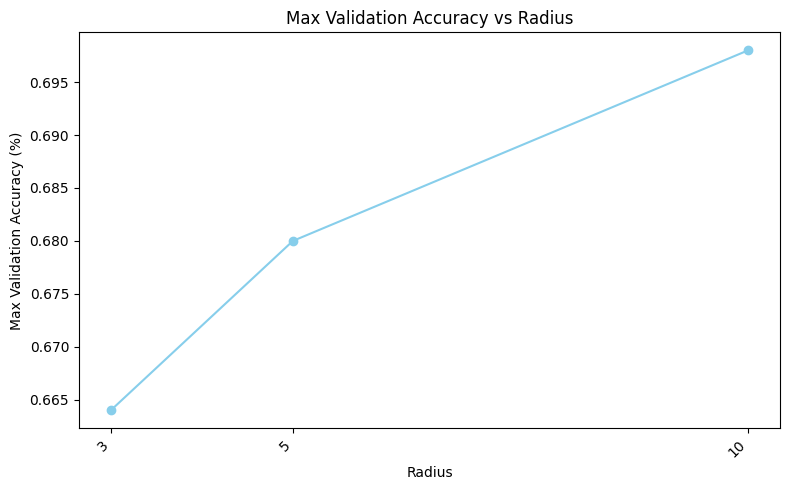

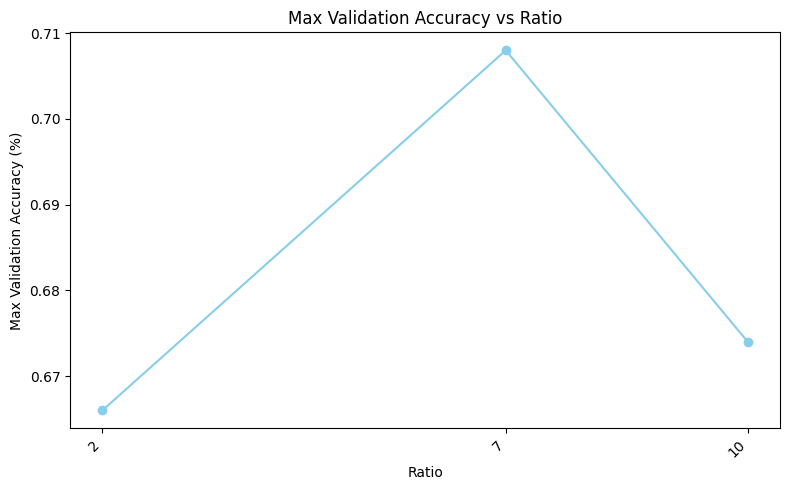

In [ ]:
import matplotlib.pyplot as plt

def plot_max_validation_accuracy(results, x_label, title):

    fig, ax = plt.subplots(figsize=(8, 5))

    # Max Validation Accuracy Plot
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Max Validation Accuracy (%)")

    max_valid_accuracies = []
    x_values = []

    for label, values in results.items():
        _, _, _, valid_accuracies = values

        # Max Validation Accuracy
        max_valid_accuracy = max(valid_accuracies)
        max_valid_accuracies.append(max_valid_accuracy)

        # Extract the relevant value from the label
        if "Embedding Dim" in label:
            x_value = int(label.split()[-1])
        elif "Radius" in label:
            x_value = int(label.split()[-1])
        elif "Ratio" in label:
            x_value = int(label.split()[-1])
        else:
            continue

        x_values.append(x_value)

    # Sort x_values and accuracies for better plotting
    sorted_indices = sorted(range(len(x_values)), key=lambda k: x_values[k])
    x_values = [x_values[i] for i in sorted_indices]
    max_valid_accuracies = [max_valid_accuracies[i] for i in sorted_indices]

    # Plot Max Validation Accuracy
    ax.plot(x_values, max_valid_accuracies, marker='o', linestyle='-', color='skyblue')

    plt.xticks(x_values, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


plot_max_validation_accuracy(results_embed, "Embedding Dimension", "Max Validation Accuracy vs Embedding Dimension")
plot_max_validation_accuracy(results_radius, "Radius", "Max Validation Accuracy vs Radius")
plot_max_validation_accuracy(results_ratio, "Ratio", "Max Validation Accuracy vs Ratio")

Epoch 1: train_loss: 1.0086, train_accuracy: 0.5312, valid_loss: 0.7674, valid_accuracy: 0.5730
Epoch 2: train_loss: 0.5668, train_accuracy: 0.8594, valid_loss: 0.6560, valid_accuracy: 0.6430
Epoch 3: train_loss: 0.3403, train_accuracy: 0.9375, valid_loss: 0.6307, valid_accuracy: 0.6400
Epoch 4: train_loss: 0.1374, train_accuracy: 1.0000, valid_loss: 0.6179, valid_accuracy: 0.6640
Epoch 5: train_loss: 0.0526, train_accuracy: 1.0000, valid_loss: 0.6027, valid_accuracy: 0.6720
Epoch 6: train_loss: 0.0240, train_accuracy: 1.0000, valid_loss: 0.6039, valid_accuracy: 0.6770
Epoch 7: train_loss: 0.0134, train_accuracy: 1.0000, valid_loss: 0.6056, valid_accuracy: 0.6770
Epoch 8: train_loss: 0.0094, train_accuracy: 1.0000, valid_loss: 0.6104, valid_accuracy: 0.6720
Epoch 9: train_loss: 0.0073, train_accuracy: 1.0000, valid_loss: 0.6113, valid_accuracy: 0.6760
Epoch 10: train_loss: 0.0057, train_accuracy: 1.0000, valid_loss: 0.6142, valid_accuracy: 0.6770
Epoch 1: train_loss: 1.0661, train_accu

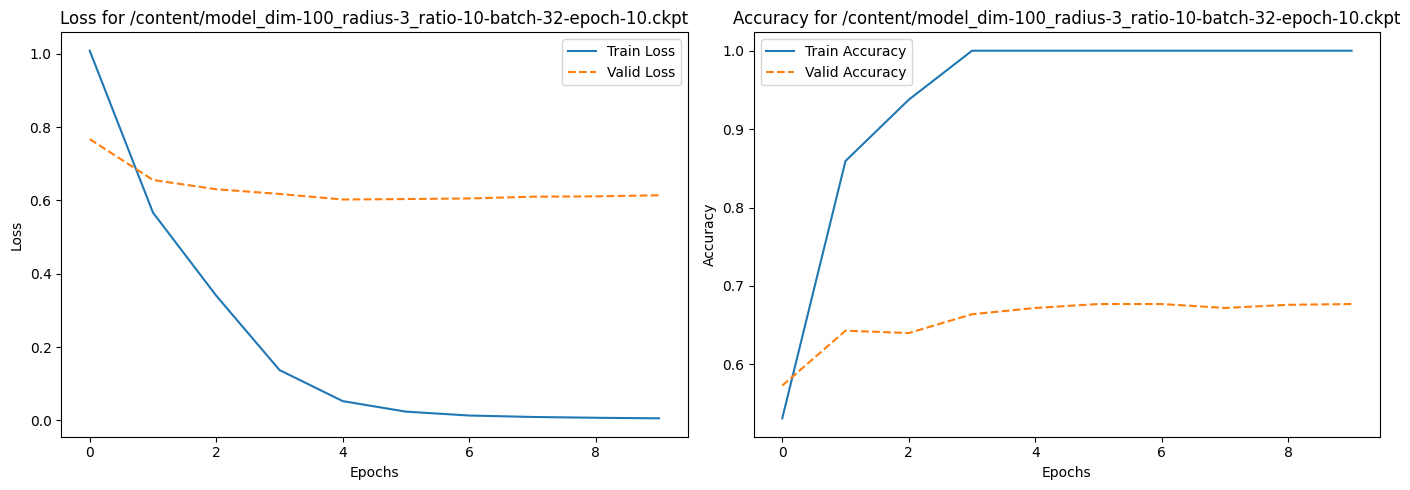

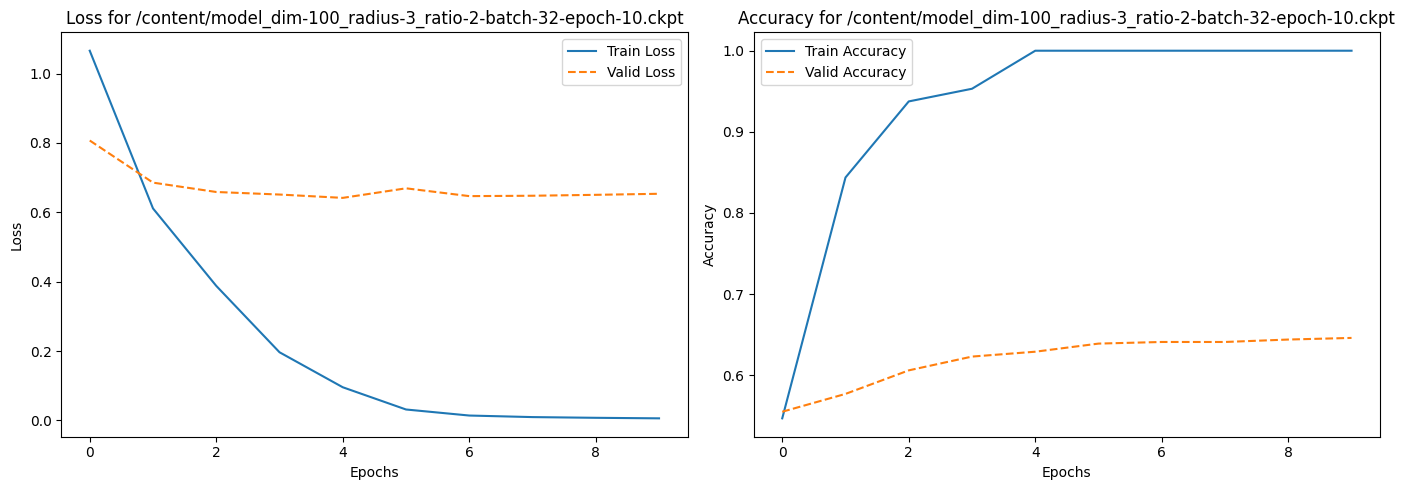

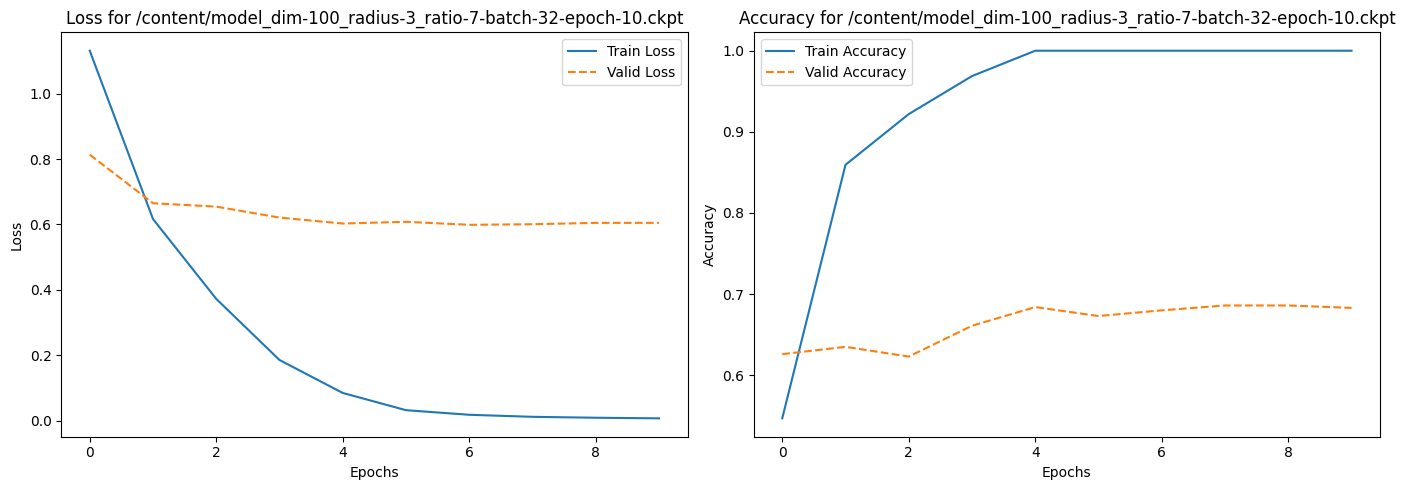

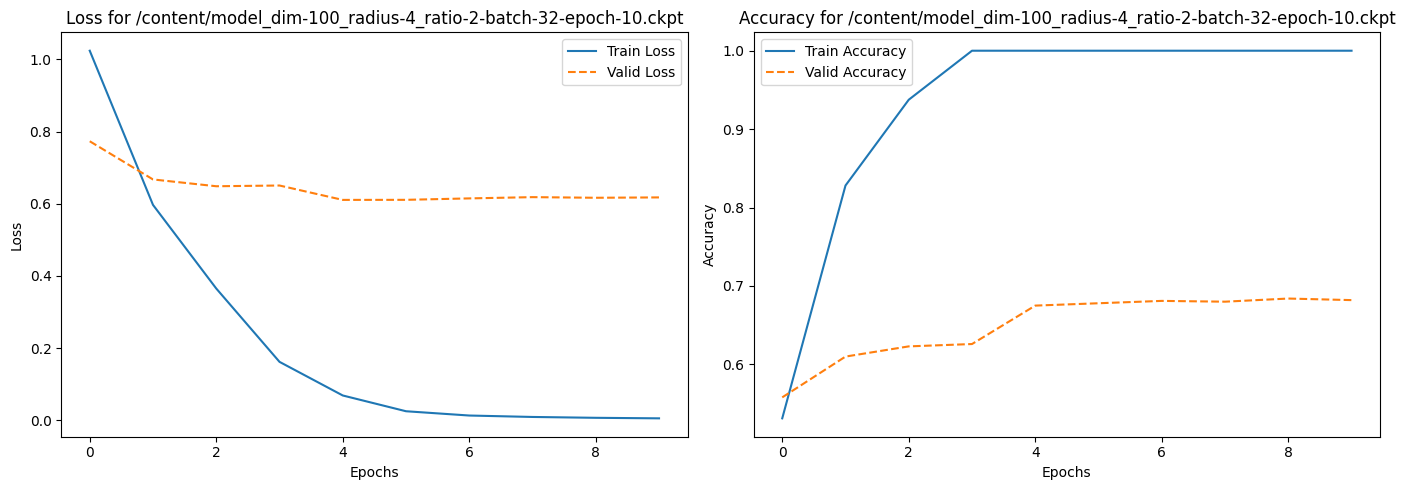

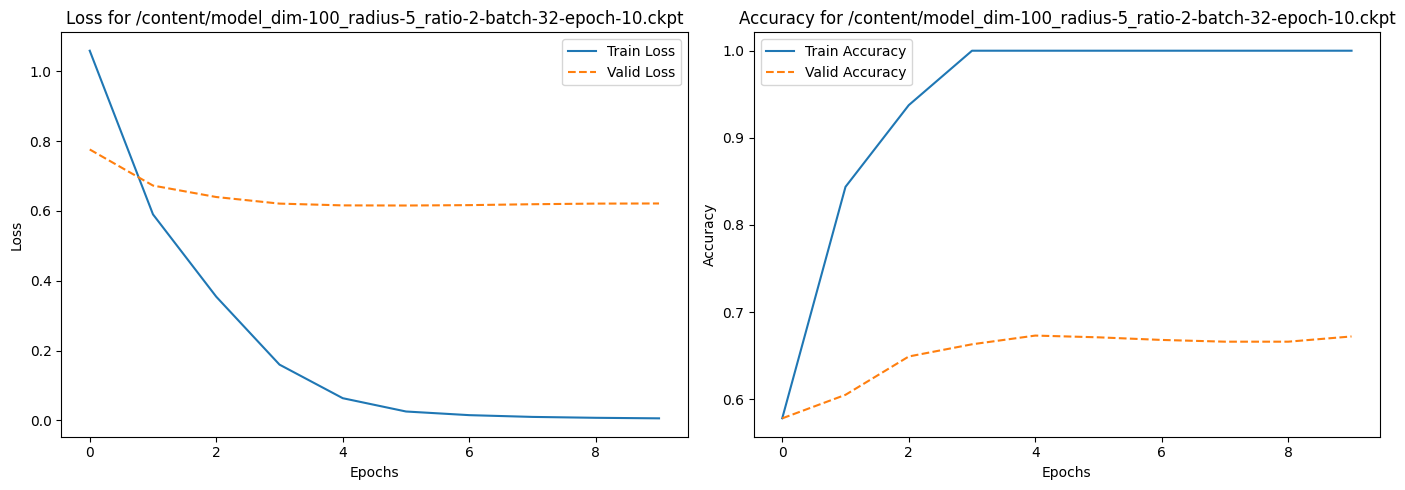

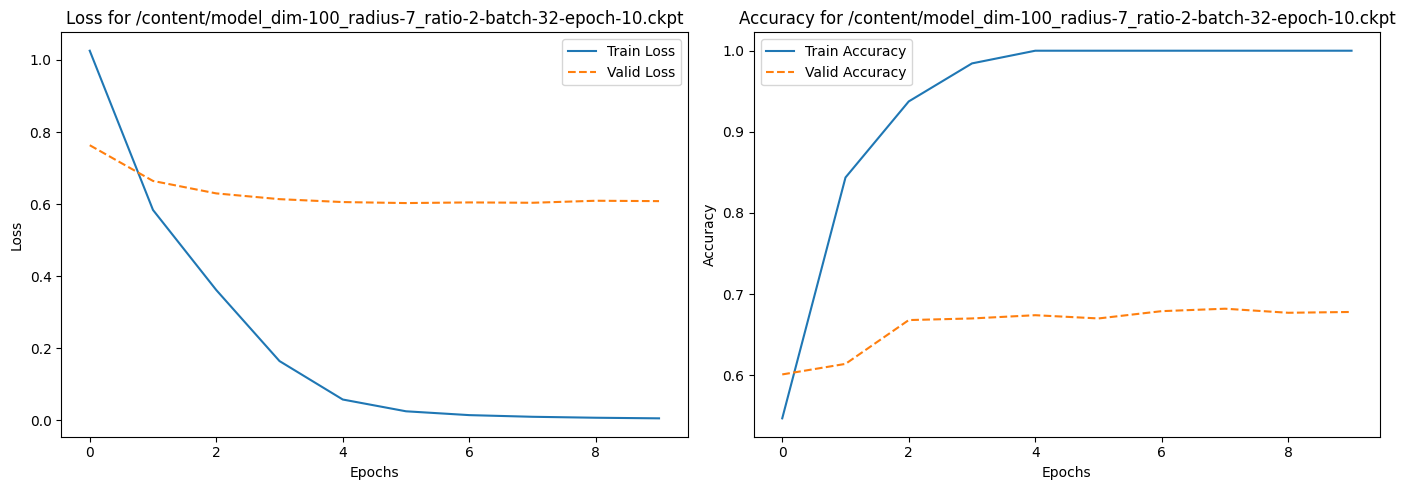

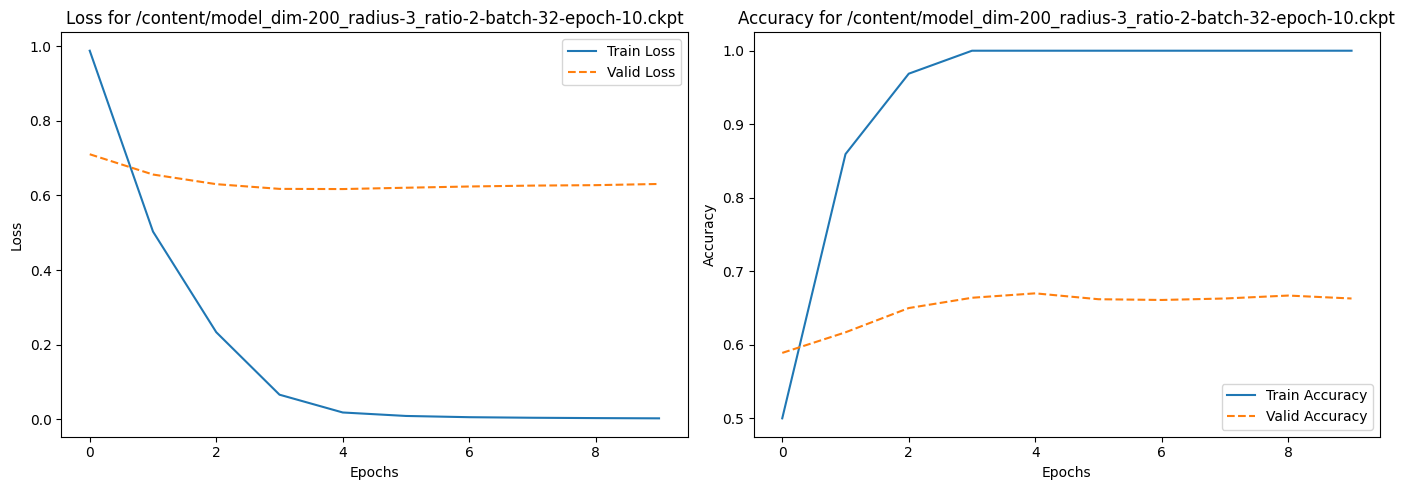

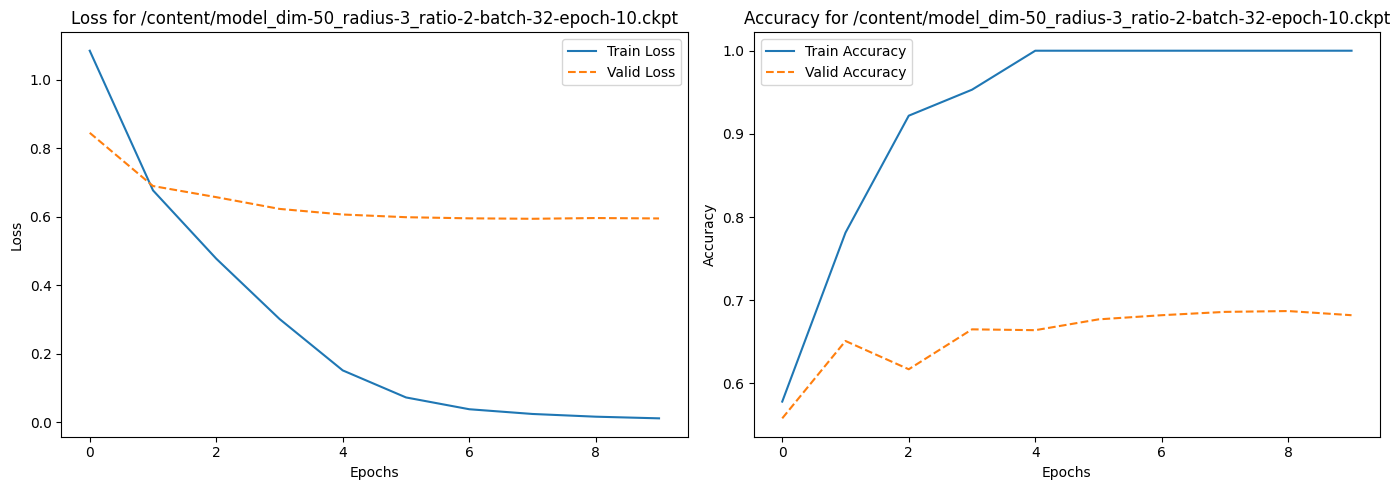

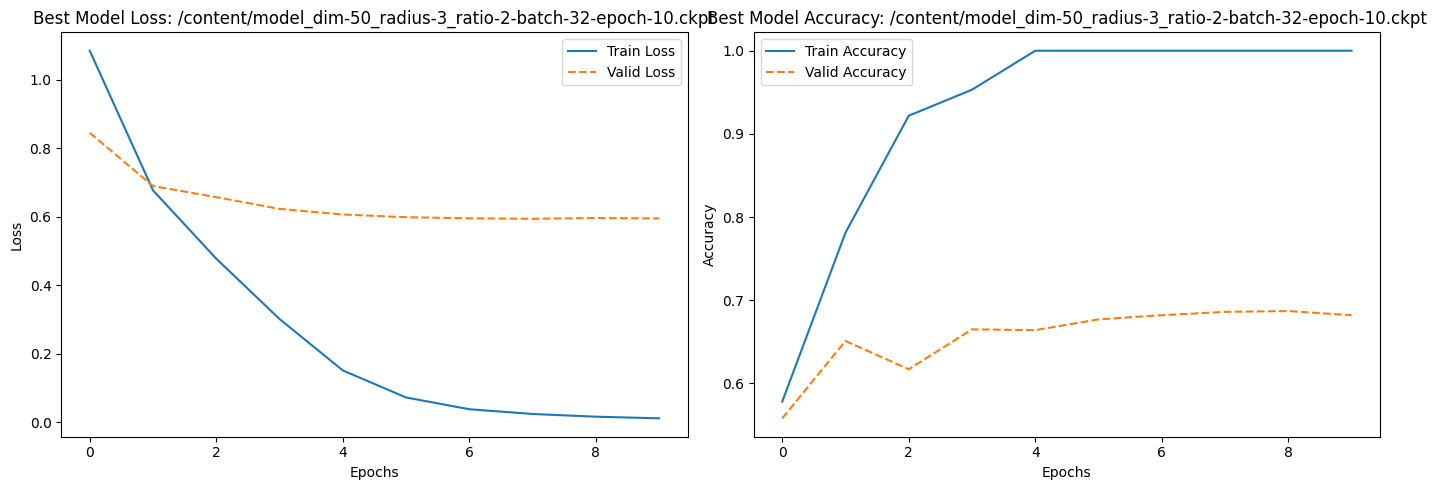

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define a function to train and store results
def train_and_store(model, train_dataloader, valid_dataloader, lr, n_epochs, losses, accuracies):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(DEVICE)
    for epoch in range(n_epochs):
        train_loss, train_accuracy = train_one_epoch(train_dataloader, model, optimizer, criterion)
        valid_loss, valid_accuracy = validation_step(valid_dataloader, model, criterion)
        print(f"Epoch {epoch + 1}: train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}, valid_loss: {valid_loss:.4f}, valid_accuracy: {valid_accuracy:.4f}")
        losses[0].append(train_loss)
        losses[1].append(valid_loss)
        accuracies[0].append(train_accuracy)
        accuracies[1].append(valid_accuracy)

# Load models and train them
models = {
    "/content/model_dim-100_radius-3_ratio-10-batch-32-epoch-10.ckpt": load_model("/content/model_dim-100_radius-3_ratio-10-batch-32-epoch-10.ckpt", len(tokenizer), 100, 4),
    "/content/model_dim-100_radius-3_ratio-2-batch-32-epoch-10.ckpt": load_model("/content/model_dim-100_radius-3_ratio-2-batch-32-epoch-10.ckpt", len(tokenizer), 100, 4),
    "/content/model_dim-100_radius-3_ratio-7-batch-32-epoch-10.ckpt": load_model("/content/model_dim-100_radius-3_ratio-7-batch-32-epoch-10.ckpt", len(tokenizer), 100, 4),
    "/content/model_dim-100_radius-4_ratio-2-batch-32-epoch-10.ckpt": load_model("/content/model_dim-100_radius-4_ratio-2-batch-32-epoch-10.ckpt", len(tokenizer), 100, 4),
    "/content/model_dim-100_radius-5_ratio-2-batch-32-epoch-10.ckpt": load_model("/content/model_dim-100_radius-5_ratio-2-batch-32-epoch-10.ckpt", len(tokenizer), 100, 4),
    "/content/model_dim-100_radius-7_ratio-2-batch-32-epoch-10.ckpt": load_model("/content/model_dim-100_radius-7_ratio-2-batch-32-epoch-10.ckpt", len(tokenizer), 100, 4),
    "/content/model_dim-200_radius-3_ratio-2-batch-32-epoch-10.ckpt": load_model("/content/model_dim-200_radius-3_ratio-2-batch-32-epoch-10.ckpt", len(tokenizer), 200, 4),
    "/content/model_dim-50_radius-3_ratio-2-batch-32-epoch-10.ckpt": load_model("/content/model_dim-50_radius-3_ratio-2-batch-32-epoch-10.ckpt", len(tokenizer), 50, 4)
}

results = {}
for model_path, model in models.items():
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    train_and_store(model, train_dataloader, valid_dataloader, lr=0.01, n_epochs=10,
                    losses=[train_losses, valid_losses], accuracies=[train_accuracies, valid_accuracies])
    results[model_path] = (train_losses, train_accuracies, valid_losses, valid_accuracies)

# Identify the best model based on validation accuracy
best_model_path, best_model_results = max(results.items(), key=lambda x: max(x[1][3]))
best_val_acc = max(best_model_results[3])
best_epoch = best_model_results[3].index(best_val_acc)

# Display best model metrics
data = {
    "Model Path": [best_model_path],
    "Best Validation Accuracy": [best_val_acc],
    "Epoch": [best_epoch]
}
best_model_df = pd.DataFrame(data)
print(best_model_df)

# Plot each model separately with two plots per row
for model_path, (train_losses, train_accuracies, valid_losses, valid_accuracies) in results.items():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].set_title(f"Loss for {model_path}")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].plot(train_losses, label="Train Loss")
    axes[0].plot(valid_losses, label="Valid Loss", linestyle="dashed")
    axes[0].legend()

    axes[1].set_title(f"Accuracy for {model_path}")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].plot(train_accuracies, label="Train Accuracy")
    axes[1].plot(valid_accuracies, label="Valid Accuracy", linestyle="dashed")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Plot best model separately
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].set_title(f"Best Model Loss: {best_model_path}")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].plot(best_model_results[0], label="Train Loss")
axes[0].plot(best_model_results[2], label="Valid Loss", linestyle="dashed")
axes[0].legend()

axes[1].set_title(f"Best Model Accuracy: {best_model_path}")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].plot(best_model_results[1], label="Train Accuracy")
axes[1].plot(best_model_results[3], label="Valid Accuracy", linestyle="dashed")
axes[1].legend()

plt.tight_layout()
plt.show()

## **Analysis**

The ablation study shows that Word2Vec model parameters affect classification performance.

Increasing the **embedding dimension (model_dim)** improves validation accuracy up to a certain threshold, but beyond that, it does not yield significant gains and can lead to instability.

A context window **(radius R)** that is too small limits the learning of word relationships, while a moderate radius enhances performance; however, an excessively **large radius** introduces noise and slightly degrades results.

Similarly, a low negative sampling **ratio (ratio K)** results in limited generalization, whereas an intermediate ratio improves model robustness; however, a very high value can slow down training without providing clear benefits.

These findings highlight the importance of a balanced choice of hyperparameters, where moderate values for each parameter help optimize accuracy without the risk of overfitting.

Among these parameters, the **embedding dimension (model_dim) and context window size (radius R)** appear to have the most significant influence on overall performance, directly impacting the model's ability to capture semantic and contextual relationships.







